In [1]:
###==================================
# Section: Importing Libraries
###==================================

In [2]:
# File System and Data Handling

from pathlib import Path
from collections import Counter, defaultdict
import yaml

In [3]:
# Image Processing
from PIL import Image, ImageFile, ImageDraw, ImageStat, ImageFilter, UnidentifiedImageError
import cv2

In [4]:
# Basic 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [5]:
# Utility and Development
import warnings
from tqdm import tqdm
import random

In [6]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

In [7]:
###==================================
# Section: Define Paths
###==================================

In [8]:
try:
    project_root = Path.cwd().parent
    if not project_root.exists():
        raise FileNotFoundError("Invalid working directory.")
except Exception as e:
    print(f"Error finding project root: {e}")
    project_root = Path(".")

In [9]:
config_dir = project_root / 'config'
data_yaml_path = config_dir / 'data.yaml'

In [10]:
dataset_dir = project_root / 'dataset'
raw_image_dir = dataset_dir / 'raw/images'
raw_label_dir = dataset_dir / 'raw/labels'

In [11]:
reports_figures_dir = project_root / 'reports/figures/1_data_analysis'
reports_tables_dir = project_root / 'reports/tables/1_data_analysis'

In [12]:
reports_figures_dir.mkdir(parents=True, exist_ok=True)
reports_tables_dir.mkdir(parents=True, exist_ok=True)

In [13]:
###==================================
# Section: Load Dataset Metadata
###==================================

In [14]:
def load_dataset_config(yaml_path: Path):
    try:
        with open(yaml_path, 'r') as f:
            config = yaml.safe_load(f)
            num_classes = config.get('nc', 0)
            class_names = config.get('names', [f'class_{i}' for i in range(num_classes)])
            return num_classes, class_names
    except Exception as e:
        print(f"Failed to load data.yaml: {e}")
        return 0, []

In [15]:
NUM_CLASSES, CLASS_NAMES = load_dataset_config(data_yaml_path)

print(f"Loaded {NUM_CLASSES} classes from data.yaml.")
print(f"Class names: {CLASS_NAMES}")

Loaded 10 classes from data.yaml.
Class names: ['Tomato Bacterial Spot', 'Tomato Early blight', 'Tomato Late blight', 'Tomato Leaf Mold', 'Tomato Septoria leaf spot', 'Tomato Spider mites Two-spotted spider mite', 'Tomato Target Spot', 'Tomato Yellow Leaf Curl Virus', 'Tomato healthy', 'Tomato mosaic virus']


In [16]:
modified_class_names = ['Bacterial Spot', 'Early blight', 'Late blight', 'Leaf Mold', 'Septoria leaf spot',
                         'Two-spotted spider mite', 'Target Spot', 'Yellow Leaf Curl Virus', 'Healthy', 'Mosaic virus']

CLASS_NAMES = modified_class_names

class_labels_str = ", ".join(CLASS_NAMES)

print(f"Loaded {NUM_CLASSES} classes. The class labels are {class_labels_str}")

Loaded 10 classes. The class labels are Bacterial Spot, Early blight, Late blight, Leaf Mold, Septoria leaf spot, Two-spotted spider mite, Target Spot, Yellow Leaf Curl Virus, Healthy, Mosaic virus


In [17]:
###===========================================
# Section: Image-Label Consistency Check
###===========================================

In [18]:
def check_image_label_consistency(image_dir: Path, label_dir: Path, valid_exts=None):
    if valid_exts is None:
        valid_exts = ['.jpg', '.jpeg', '.png']

    # Use tqdm to visualize file loading
    image_files = {
        f.stem for f in tqdm(
            image_dir.glob("*"),
            desc="Loading images",
            unit="file"
        ) if f.suffix.lower() in valid_exts
    }

    label_files = {
        f.stem for f in tqdm(
            label_dir.glob("*.txt"),
            desc="Loading labels",
            unit="file"
        )
    }

    missing_labels = sorted(image_files - label_files) # finds image names that don't have corresponding labels.
    missing_images = sorted(label_files - image_files) # finds label names that don't have corresponding images.

    return missing_labels, missing_images, len(image_files), len(label_files)

In [19]:
missing_labels, missing_images, num_images, num_labels = check_image_label_consistency(
    raw_image_dir, raw_label_dir
)

Loading images: 10853file [00:00, 263316.16file/s]
Loading labels: 10853file [00:00, 306335.09file/s]


In [20]:
print(f"Image-Label Matching Report:")
print(f"\n -- Total images: {num_images}")
print(f" -- Total labels: {num_labels}")
if missing_labels:
    print(f"{len(missing_labels)} images missing labels. Example: {missing_labels[0]}")
if missing_images:
    print(f"{len(missing_images)} labels missing images. Example: {missing_images[0]}")
if not missing_labels and not missing_images:
    print("\nAll images and labels are correctly paired.")

Image-Label Matching Report:

 -- Total images: 10853
 -- Total labels: 10853

All images and labels are correctly paired.


In [21]:
def draw_yolo_boxes(image: Image.Image, label_path: Path):
    """
    Draw YOLO-format bounding boxes on the image.
    """
    draw = ImageDraw.Draw(image)
    w, h = image.size

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # skip malformed lines
            class_id, x, y, bw, bh = map(float, parts)
            # Convert from normalized to pixel values
            left = (x - bw / 2) * w
            top = (y - bh / 2) * h
            right = (x + bw / 2) * w
            bottom = (y + bh / 2) * h

            # Draw rectangle
            draw.rectangle([left, top, right, bottom], outline="red", width=2)
            # Optionally draw class_id
            draw.text((left, top), str(int(class_id)), fill="red")

    return image

In [22]:
def show_and_save_images_with_bboxes(image_dir: Path, label_dir: Path, save_dir: Path,
                                     num_samples=6, valid_exts=None, filename="image_grid.png"):
    if valid_exts is None:
        valid_exts = ['.jpg', '.jpeg', '.png']

    # Get valid samples with labels > 0 KB
    image_files = [
        f for f in image_dir.glob("*") 
        if f.suffix.lower() in valid_exts and (label_dir / f"{f.stem}.txt").stat().st_size > 0
    ]
    
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for ax, image_path in zip(axes, sample_files):
        label_path = label_dir / f"{image_path.stem}.txt"
        image = Image.open(image_path).convert("RGB")
        image_with_boxes = draw_yolo_boxes(image, label_path)

        ax.imshow(image_with_boxes)
        ax.axis('off')

    for ax in axes[len(sample_files):]:
        ax.axis('off')

    plt.tight_layout()

    # Ensure save directory exists
    save_dir.mkdir(parents=True, exist_ok=True)
    save_path = save_dir / filename
    plt.savefig(save_path, dpi=300)
    plt.show()

    print(f"Image grid saved to: {save_path}")

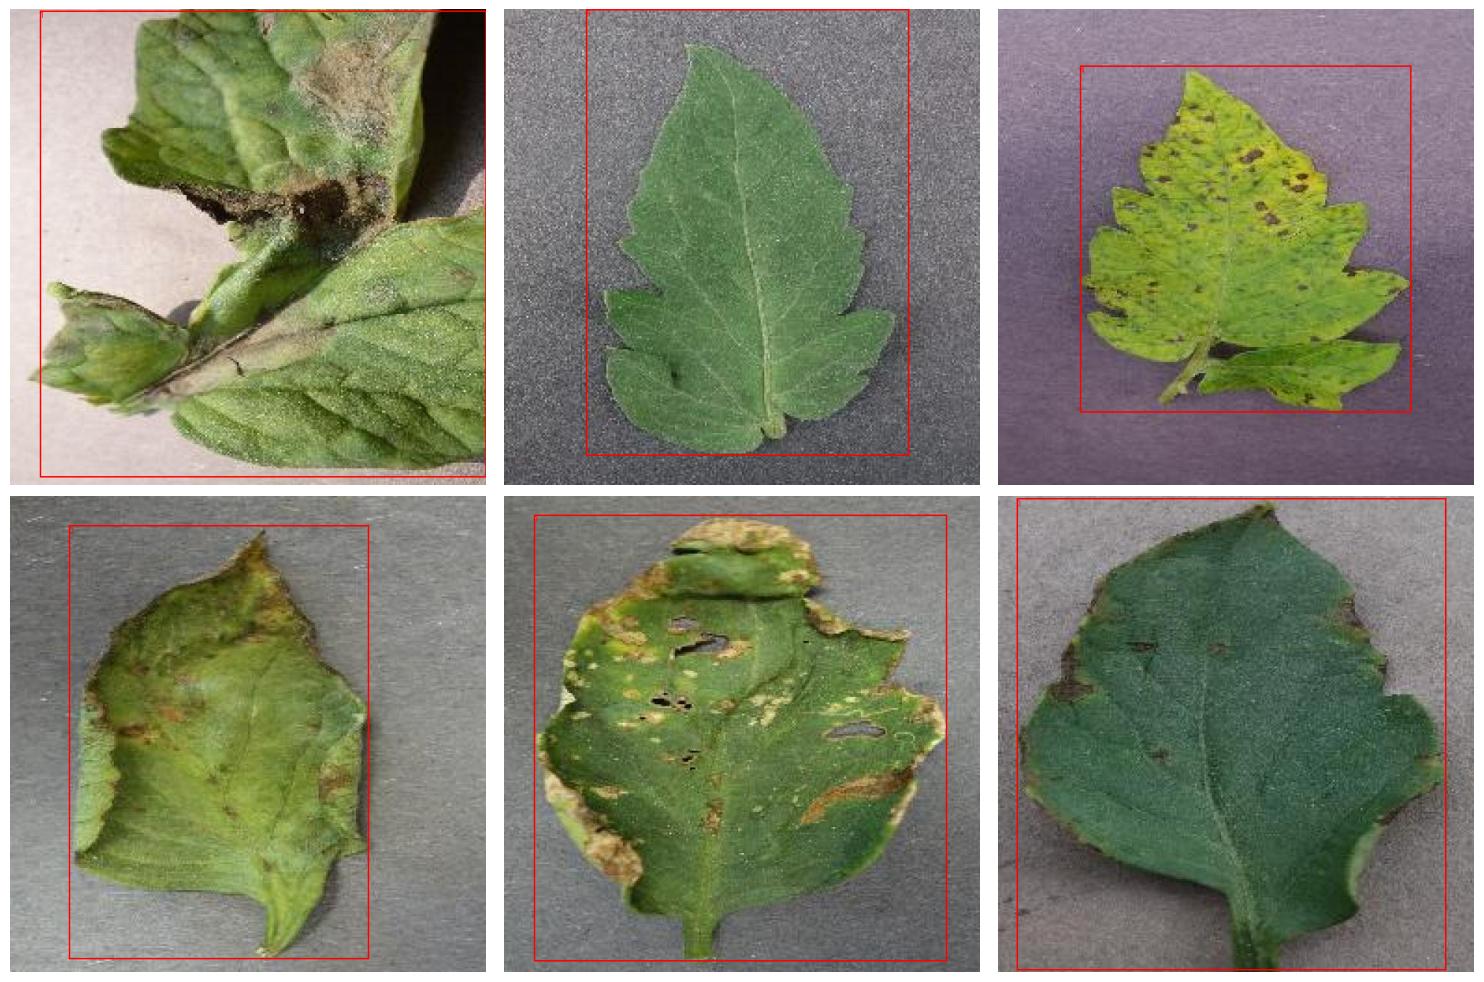

Image grid saved to: C:\Users\pavan\Desktop\Tomato-Disease\reports\figures\1_data_analysis\annotated_image_grid.png


In [23]:
# Save to this location
show_and_save_images_with_bboxes(
    image_dir=raw_image_dir,
    label_dir=raw_label_dir,
    save_dir=reports_figures_dir,
    num_samples=6,
    filename="annotated_image_grid.png"
)

In [24]:
# Utility function to check image blur using Laplacian
def detect_blur(image, threshold=100.0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var < threshold, laplacian_var

In [25]:
# Initialize containers
img_paths = sorted(list(raw_image_dir.glob('*.jpg')))
data = []

print(f"Found {len(img_paths)} images. Beginning analysis...")

for path in tqdm(img_paths):
    try:
        # Open image with PIL to ensure safe loading
        with Image.open(path) as pil_img:
            image_format = pil_img.format
            img = np.array(pil_img.convert('RGB'))  # Convert to RGB for consistency

        # Convert to OpenCV (BGR)
        img_cv = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        height, width, channels = img_cv.shape

        # Convert to grayscale
        gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)

        # Brightness and contrast
        brightness = np.mean(gray)
        contrast = gray.std()

        # Blur detection
        blur_flag, blur_score = detect_blur(img_cv)  # You must define this function

        # Append collected data
        data.append({
            'filename': path.name,
            'width': width,
            'height': height,
            'aspect_ratio': round(width / height, 2),
            'channels': channels,
            'brightness': round(brightness, 2),
            'contrast': round(contrast, 2),
            'format': image_format,
            'is_blurry': blur_flag,
            'blur_score': round(blur_score, 2)
        })

    except (UnidentifiedImageError, ValueError, OSError, AttributeError) as e:
        print(f"Corrupted or unreadable image: {path.name} | Error: {str(e)}")

Found 10853 images. Beginning analysis...


100%|███████████████████████████████████████████████████████████████████████████| 10853/10853 [01:39<00:00, 108.65it/s]


In [26]:
# Convert list of dictionaries to DataFrame
df = pd.DataFrame(data)
df

,filename,width,height,aspect_ratio,channels,brightness,contrast,format,is_blurry,blur_score
0,000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL-L...,640,640,1.0,3,104.60,21.05,JPEG,False,355.74
1,000bf685-b305-408b-91f4-37030f8e62db___GH_HL-L...,640,640,1.0,3,111.71,26.68,JPEG,False,706.86
2,000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG-...,640,640,1.0,3,115.27,36.93,JPEG,False,379.72
3,0012b9d2-2130-4a06-a834-b1f3af34f57e___RS_Erly...,640,640,1.0,3,103.98,52.03,JPEG,False,721.48
4,002213fb-b620-4593-b9ac-6a6cc119b100___Com_G_T...,640,640,1.0,3,109.55,48.56,JPEG,False,937.26
...,...,...,...,...,...,...,...,...,...,...
10848,Tomato___Tomato_mosaic_virus_original_fcf80369...,640,640,1.0,3,111.45,27.32,JPEG,False,484.87
10849,Tomato___Tomato_mosaic_virus_original_fcf80369...,640,640,1.0,3,111.45,27.32,JPEG,False,484.87
10850,Tomato___Tomato_mosaic_virus_original_fcf80369...,640,640,1.0,3,111.45,27.31,JPEG,False,485.06
10851,Tomato___Tomato_mosaic_virus_original_feabce4c...,640,640,1.0,3,122.27,32.33,JPEG,False,1389.40


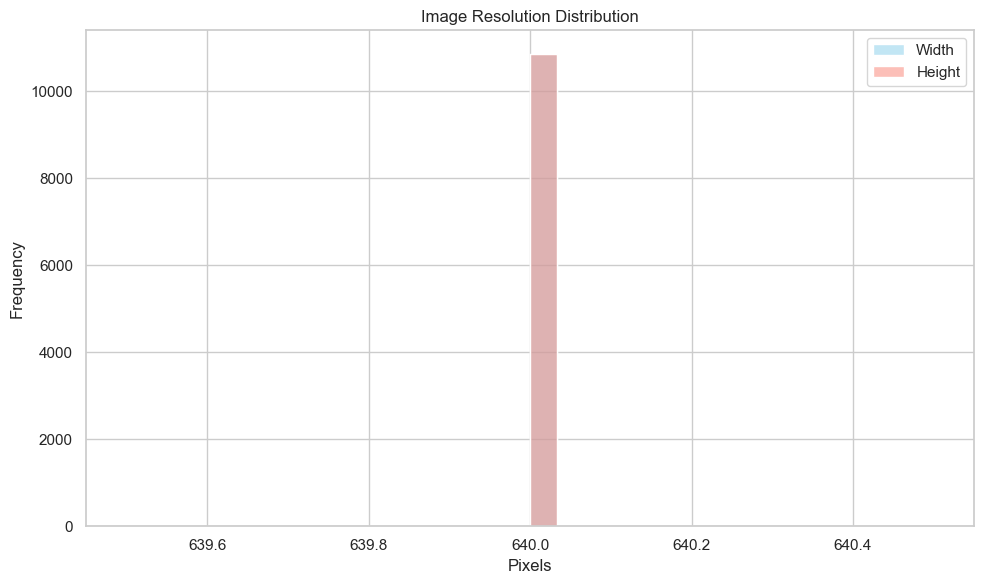

In [27]:
# Plot resolution distribution
plt.figure(figsize=(10,6))
sns.histplot(df['width'], bins=30, label='Width', color='skyblue', kde=True)
sns.histplot(df['height'], bins=30, label='Height', color='salmon', kde=True)
plt.title("Image Resolution Distribution")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(reports_figures_dir / "resolution_distribution.png")
plt.show()
plt.close()

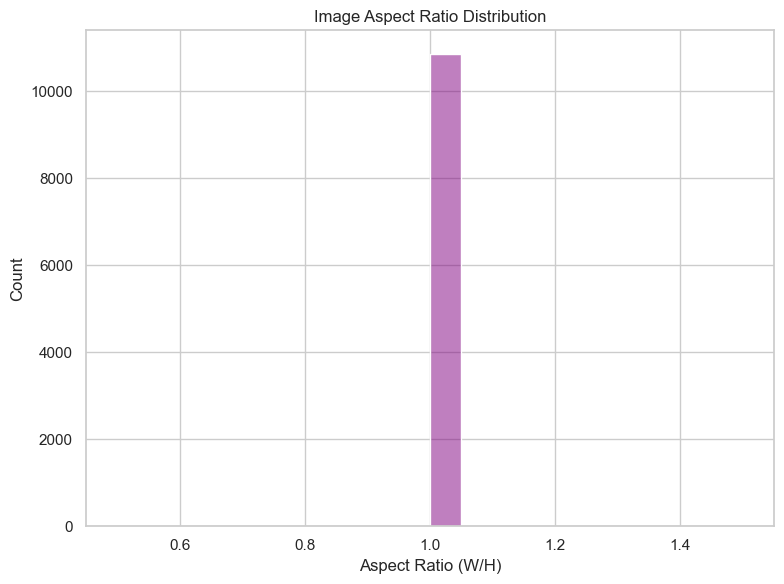

In [28]:
# Aspect ratio distribution
plt.figure(figsize=(8,6))
sns.histplot(df['aspect_ratio'], bins=20, kde=True, color='purple')
plt.title("Image Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (W/H)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig(reports_figures_dir / "aspect_ratio_distribution.png")
plt.show()
plt.close()

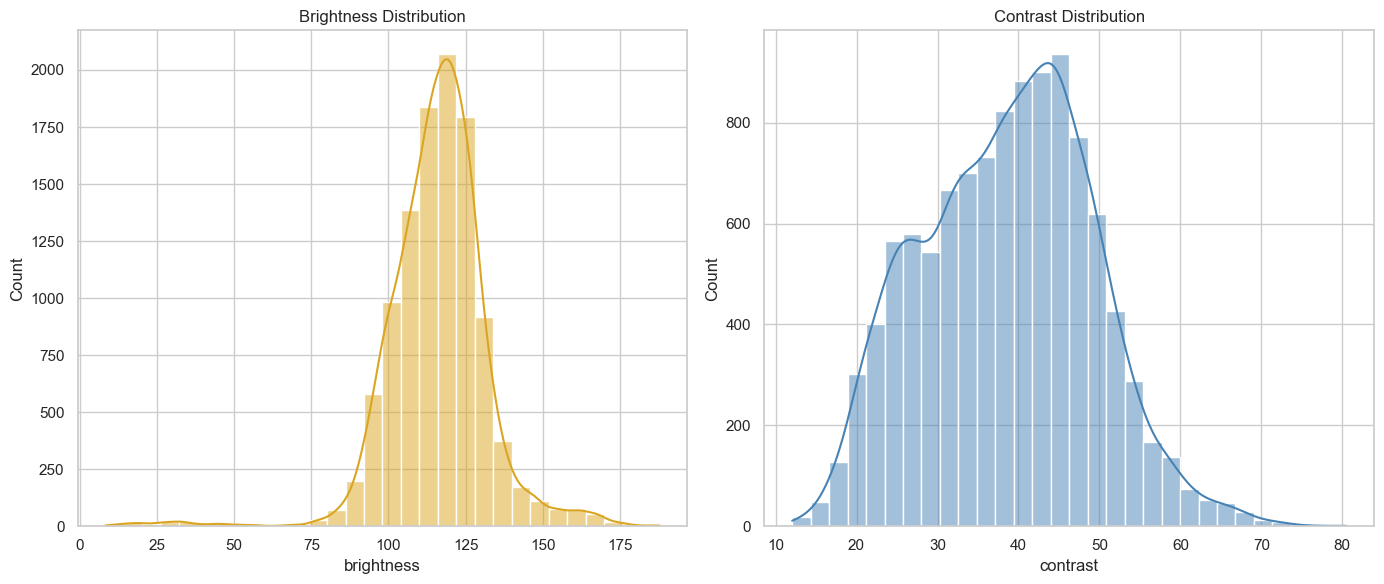

In [29]:
# Brightness & contrast distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(df['brightness'], bins=30, ax=ax[0], color='goldenrod', kde=True)
ax[0].set_title("Brightness Distribution")
sns.histplot(df['contrast'], bins=30, ax=ax[1], color='steelblue', kde=True)
ax[1].set_title("Contrast Distribution")
plt.tight_layout()
plt.savefig(reports_figures_dir / "brightness_contrast.png")
plt.show()
plt.close()

In [30]:
# Image format stats
format_counts = df['format'].value_counts()
format_counts.to_csv(reports_tables_dir / "image_format_counts.csv")

In [31]:
# Blur statistics
blur_stats = df['is_blurry'].value_counts()
blur_stats.to_csv(reports_tables_dir / "blur_detection_counts.csv")
print("Blur Detection:")
print(blur_stats)

Blur Detection:
is_blurry
False    9413
True     1440
Name: count, dtype: int64


In [32]:
###==================================
# Section ~ 5: Image Property Analysis
###==================================

In [33]:
def get_bounding_box_stats(label_dir: Path):
    objects_per_image = []
    bbox_ratios = []

    for label_file in tqdm(label_dir.glob("*.txt"), desc="Bounding Box Stats"):
        try:
            with open(label_file) as f:
                lines = [line.strip() for line in f if line.strip()]
                objects_per_image.append(len(lines))
                for line in lines:
                    parts = line.split()
                    if len(parts) >= 5:
                        w, h = float(parts[3]), float(parts[4])
                        bbox_ratios.append(w / h if h != 0 else 0)
        except Exception as e:
            print(f"⚠️ {label_file.name}: {e}")

    return objects_per_image, bbox_ratios

In [34]:
objects_per_image, bbox_ratios = get_bounding_box_stats(raw_label_dir)

Bounding Box Stats: 10853it [00:00, 18915.68it/s]


In [35]:
# === Data Containers ===
image_stats = []
label_stats = []
class_counter = Counter()
missing_labels = []
empty_labels = []

In [36]:
# === Image & Label Analysis ===
image_paths = sorted(raw_image_dir.glob("*.jpg"))

for img_path in image_paths:
    img = cv2.imread(str(img_path))
    if img is None:
        continue

    h, w = img.shape[:2]
    aspect_ratio = round(w / h, 2)
    image_stats.append({'file': img_path.name, 'width': w, 'height': h, 'aspect_ratio': aspect_ratio})

    label_path = raw_label_dir / (img_path.stem + ".txt")
    if not label_path.exists():
        missing_labels.append(img_path.name)
        continue

    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()

        valid_lines = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            try:
                class_id = int(parts[0])
                class_counter[class_id] += 1
                valid_lines.append(line)
            except ValueError:
                continue

        if not valid_lines:
            empty_labels.append(img_path.name)
        else:
            label_stats.append({'file': label_path.name, 'num_boxes': len(valid_lines)})

    except Exception as e:
        print(f"Error processing {label_path.name}: {e}")
        continue

In [37]:
# ========================
# Convert to DataFrames
# ========================
df_images = pd.DataFrame(image_stats)
df_labels = pd.DataFrame(label_stats)

In [38]:
class_id_to_name = {
    0: "Bacterial Spot",
    1: "Early blight",
    2: "Late blight",
    3: "Leaf Mold",
    4: "Septoria leaf spot",
    5: "Two-spotted spider mite",
    6: "Target Spot",
    7: "Yellow Leaf Curl Virus",
    8: "Healthy",
    9: "Mosaic virus"
}
df_classes = pd.DataFrame(list(class_counter.items()), columns=["Class", "Count"])
df_classes["Class_Name"] = df_classes["Class"].map(class_id_to_name)
df_classes = df_classes[["Class", "Class_Name", "Count"]]  # Optional: reorder columns
df_classes["Percentage"] = df_classes["Count"] / df_classes["Count"].sum() * 100

In [39]:
# ========================
# Summary Statistics
# ========================
print(f"Total Images: {len(df_images)}")
print(f"Total Labels: {len(df_labels)}")
print(f"Missing Labels: {len(missing_labels)}")
print(f"Empty Labels: {len(empty_labels)}")
print(f"Number of Classes: {len(class_counter)}")
if not df_labels.empty:
    print(f"Avg Boxes per Image: {df_labels['num_boxes'].mean():.2f}")
    print(f"Min Boxes per Image: {df_labels['num_boxes'].min()}")
    print(f"Max Boxes per Image: {df_labels['num_boxes'].max()}")

Total Images: 10853
Total Labels: 10687
Missing Labels: 0
Empty Labels: 166
Number of Classes: 10
Avg Boxes per Image: 1.00
Min Boxes per Image: 1
Max Boxes per Image: 3


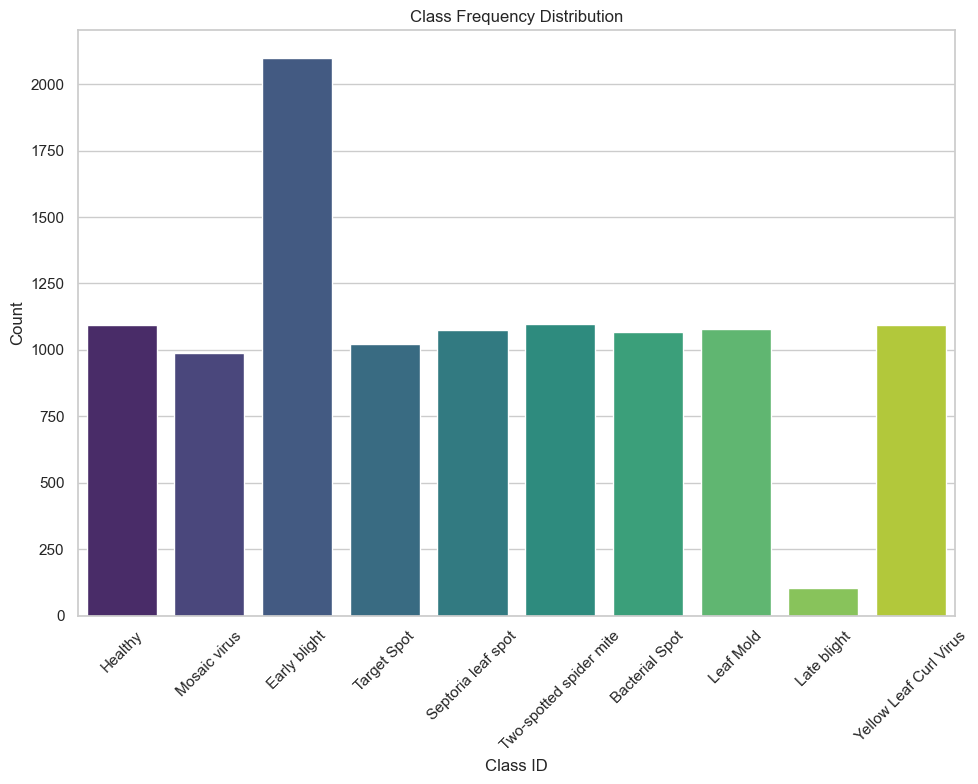

In [40]:
# === Plots ===
# Class Distribution Bar Plot
plt.figure(figsize=(10, 8))
sns.barplot(x="Class_Name", y="Count", data=df_classes, palette="viridis")
plt.title("Class Frequency Distribution")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(reports_figures_dir / "class_frequency_distribution.png")
plt.show()

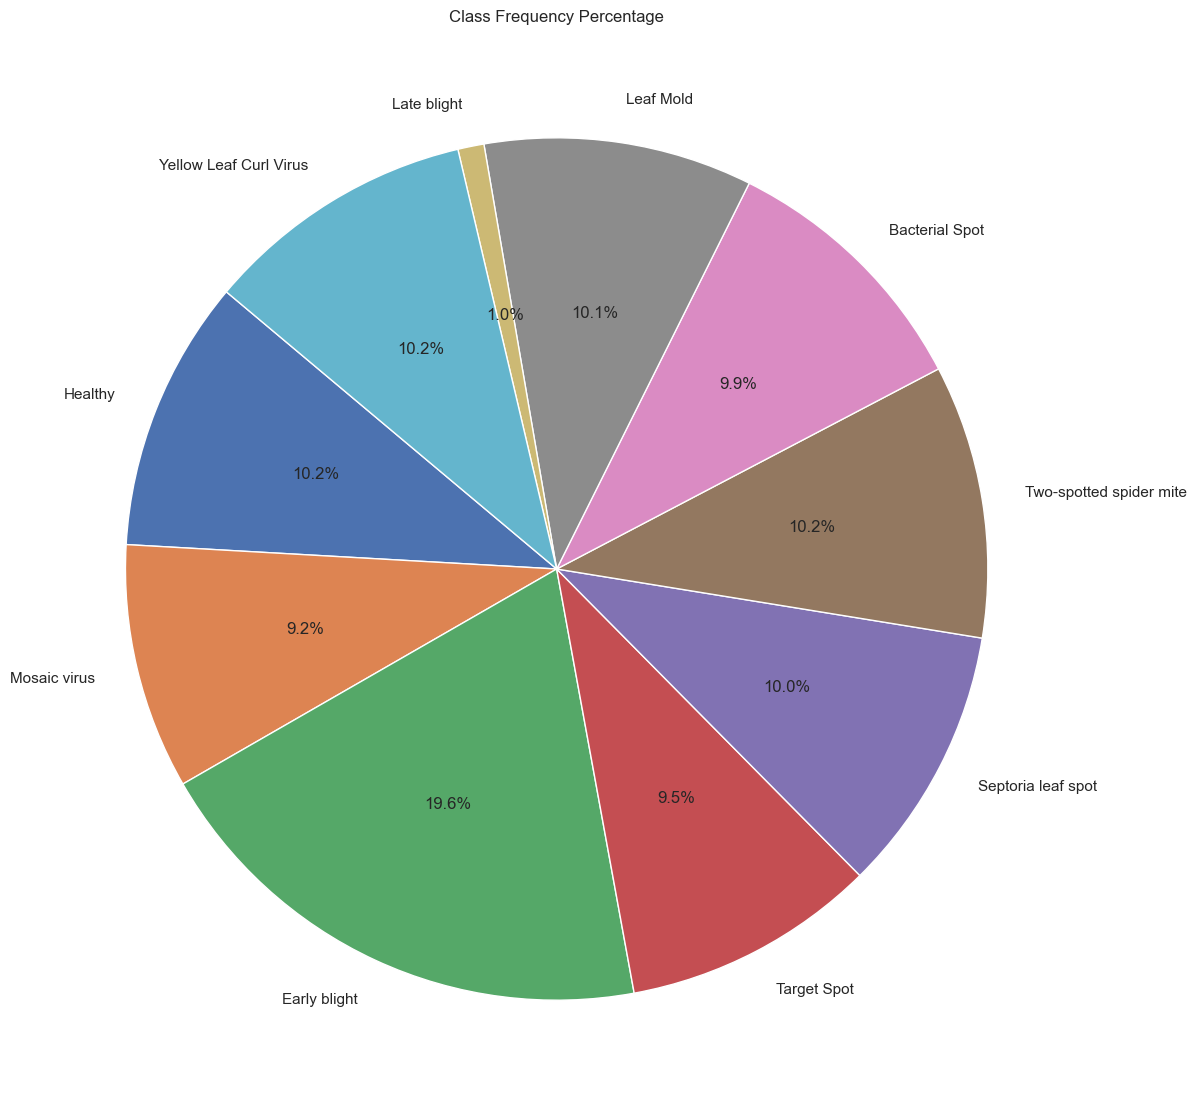

In [41]:
# Class Distribution Pie Chart
plt.figure(figsize=(14, 14))
plt.pie(df_classes["Count"], labels=df_classes["Class_Name"], autopct="%1.1f%%", startangle=140)
plt.title("Class Frequency Percentage")
plt.savefig(reports_figures_dir / "class_frequency_percentage.png")
plt.show()

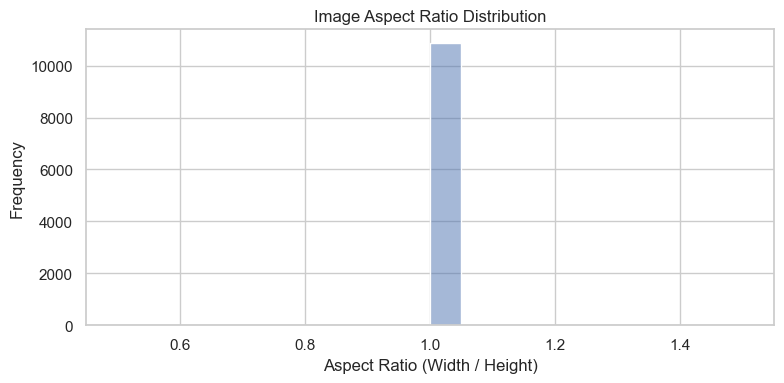

In [42]:
# Image Aspect Ratio Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df_images["aspect_ratio"], bins=20, kde=True)
plt.title("Image Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig(reports_figures_dir / "Image_aspect_ratio.png")
plt.show()

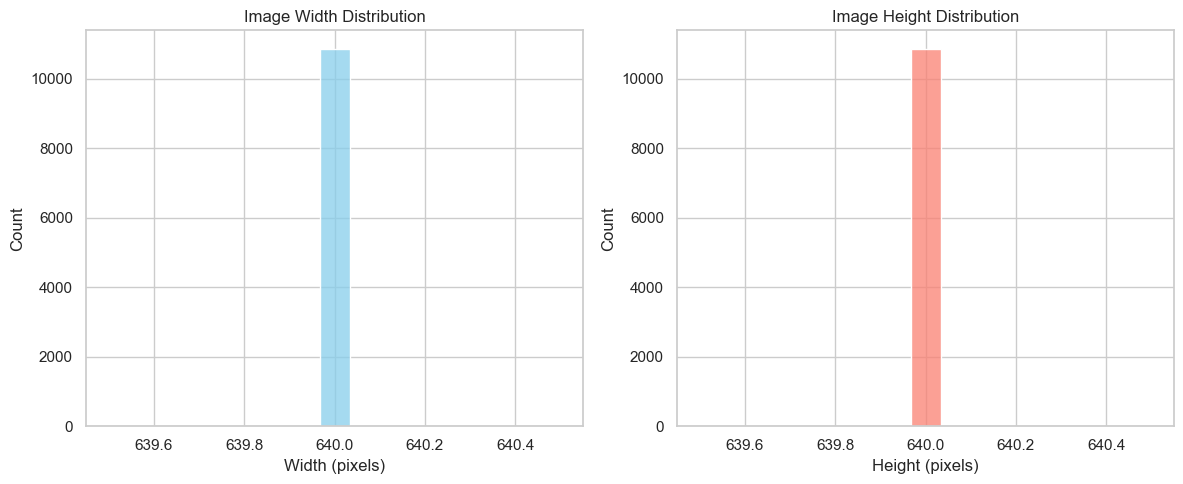

In [43]:
# Image Size Distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_images["width"], bins=15, color="skyblue")
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")

plt.subplot(1, 2, 2)
sns.histplot(df_images["height"], bins=15, color="salmon")
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.tight_layout()
plt.savefig(reports_figures_dir / "Image_distribution.png")
plt.show()

In [44]:
###=================
# Section ~ 6: Bounding Box Statistics
###=================

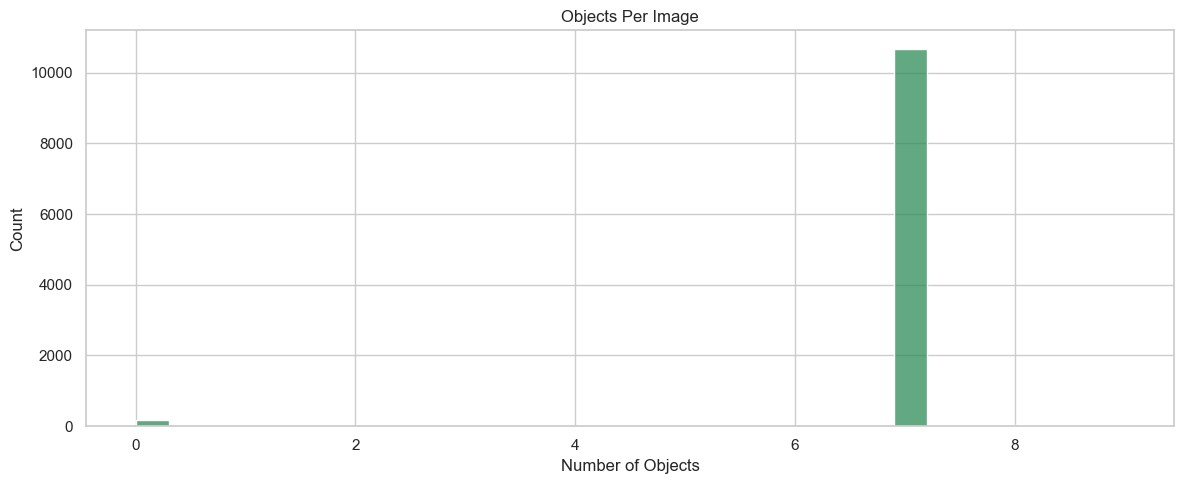

In [45]:
# Objects per image histogram
plt.figure(figsize=(12, 5))
sns.histplot(objects_per_image, bins=30, color='seagreen')
plt.title("Objects Per Image")
plt.xlabel("Number of Objects")
plt.tight_layout()
plt.savefig(reports_figures_dir / "objects_per_image_distribution.png")
plt.show()

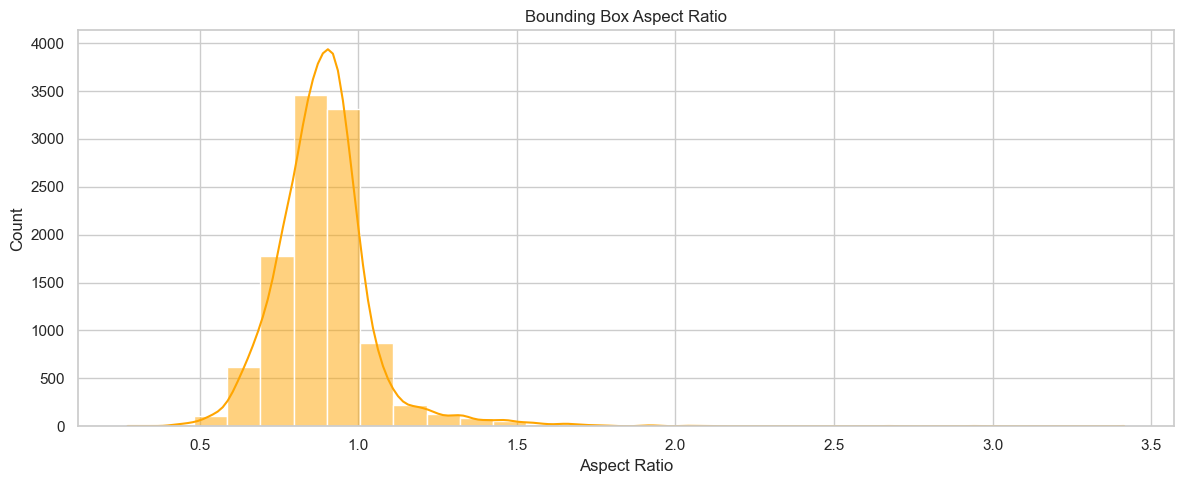

In [46]:
# BBox aspect ratio histogram
plt.figure(figsize=(12, 5))
sns.histplot(bbox_ratios, bins=30, kde=True, color='orange')
plt.title("Bounding Box Aspect Ratio")
plt.xlabel("Aspect Ratio")
plt.tight_layout()
plt.savefig(reports_figures_dir / "bbox_aspect_ratio_distribution.png")
plt.show()

In [47]:
# === Image Property Analysis ===
label_data = []
class_counts = Counter()
images_per_class = defaultdict(set)
box_area_per_class = defaultdict(list)
cooccurrence_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=int)

In [48]:
for label_file in raw_label_dir.glob("*.txt"):
    try:
        with open(label_file, "r") as f:
            lines = f.read().strip().splitlines()
    except Exception:
        continue

    if not lines:
        continue

    current_classes = set()
    image_id = label_file.stem

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue
        try:
            cls_id, x_center, y_center, width, height = map(float, parts)
            cls_id = int(cls_id)
        except ValueError:
            continue

        class_counts[cls_id] += 1
        images_per_class[cls_id].add(image_id)
        current_classes.add(cls_id)
        box_area = width * height
        box_area_per_class[cls_id].append(box_area)

    for c1 in current_classes:
        for c2 in current_classes:
            cooccurrence_matrix[c1][c2] += 1

In [49]:
# === Summary Output (Optional) ===
print("Missing label files:", len(missing_labels))
print("Empty label files:", len(empty_labels))
print("Total unique classes found:", len(class_counter))
print("Class distribution:\n", df_classes)

Missing label files: 0
Empty label files: 166
Total unique classes found: 10
Class distribution:
    Class               Class_Name  Count  Percentage
0      8                  Healthy   1094   10.209033
1      9             Mosaic virus    987    9.210526
2      1             Early blight   2097   19.568869
3      6              Target Spot   1022    9.537141
4      4       Septoria leaf spot   1074   10.022396
5      5  Two-spotted spider mite   1098   10.246361
6      0           Bacterial Spot   1066    9.947742
7      3                Leaf Mold   1079   10.069056
8      2              Late blight    105    0.979843
9      7   Yellow Leaf Curl Virus   1094   10.209033


In [50]:
# --- ANALYSIS TABLES ---
df_classes = pd.DataFrame({
    "Class ID": range(NUM_CLASSES),
    "Class" : CLASS_NAMES,
    "Frequency": [class_counts.get(i, 0) for i in range(NUM_CLASSES)],
    "Percentage (%)": [100 * class_counts.get(i, 0) / sum(class_counts.values()) if sum(class_counts.values()) > 0 else 0 for i in range(NUM_CLASSES)],
    "Images per Class": [len(images_per_class[i]) for i in range(NUM_CLASSES)],
    "Mean Box Area": [np.mean(box_area_per_class[i]) if len(box_area_per_class[i]) > 0 else 0 for i in range(NUM_CLASSES)],
    "Median Box Area": [np.median(box_area_per_class[i]) if len(box_area_per_class[i]) > 0 else 0 for i in range(NUM_CLASSES)],
    "Box Count": [len(box_area_per_class[i]) for i in range(NUM_CLASSES)]
})

In [51]:
df_classes

,Class ID,Class,Frequency,Percentage (%),Images per Class,Mean Box Area,Median Box Area,Box Count
0,0,Bacterial Spot,1066,9.947742,1059,0.779622,0.807808,1066
1,1,Early blight,2097,19.568869,2087,0.740586,0.771786,2097
2,2,Late blight,105,0.979843,99,0.588420,0.639130,105
3,3,Leaf Mold,1079,10.069056,1079,0.711324,0.718628,1079
4,4,Septoria leaf spot,1074,10.022396,1072,0.725455,0.771828,1074
5,5,Two-spotted spider mite,1098,10.246361,1098,0.611469,0.611346,1098
6,6,Target Spot,1022,9.537141,1019,0.741294,0.748672,1022
7,7,Yellow Leaf Curl Virus,1094,10.209033,1093,0.672817,0.680847,1094
8,8,Healthy,1094,10.209033,1094,0.733580,0.741148,1094
9,9,Mosaic virus,987,9.210526,987,0.555143,0.555542,987


In [52]:
missing_classes = [i for i in range(NUM_CLASSES) if class_counts.get(i, 0) == 0]
class_imbalance_ratio = max(class_counts.values()) / min([v for v in class_counts.values() if v > 0]) if len(class_counts) > 1 else 1.0
class_coverage = len([v for v in class_counts.values() if v > 0]) / NUM_CLASSES

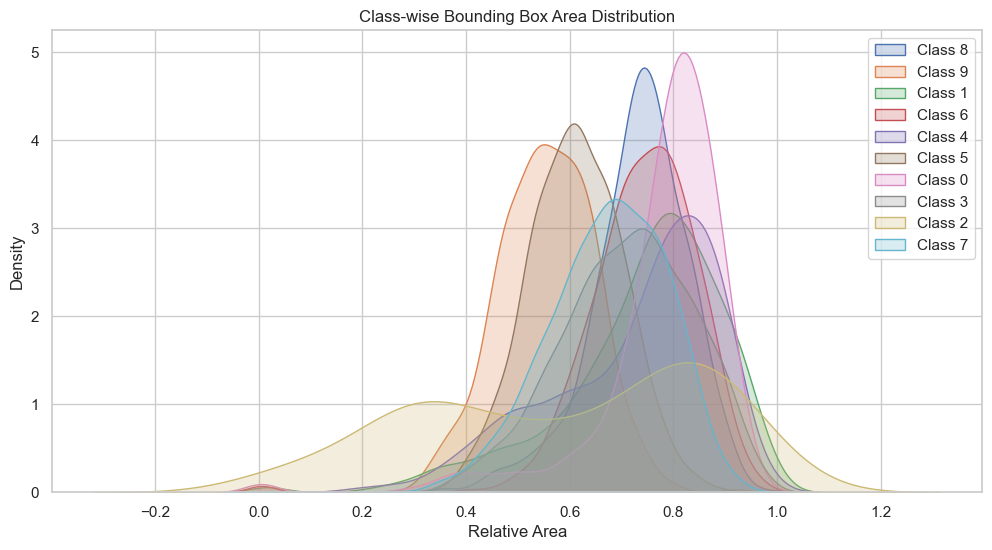

In [53]:
# Box Area Distribution (KDE)
plt.figure(figsize=(12, 6))
for cls_id, areas in box_area_per_class.items():
    if len(areas) > 1:
        sns.kdeplot(areas, label=f"Class {cls_id}", fill=True)
plt.title("Class-wise Bounding Box Area Distribution")
plt.xlabel("Relative Area")
plt.legend()
plt.savefig(reports_figures_dir / "box_area_distribution_per_class.png")
plt.show()

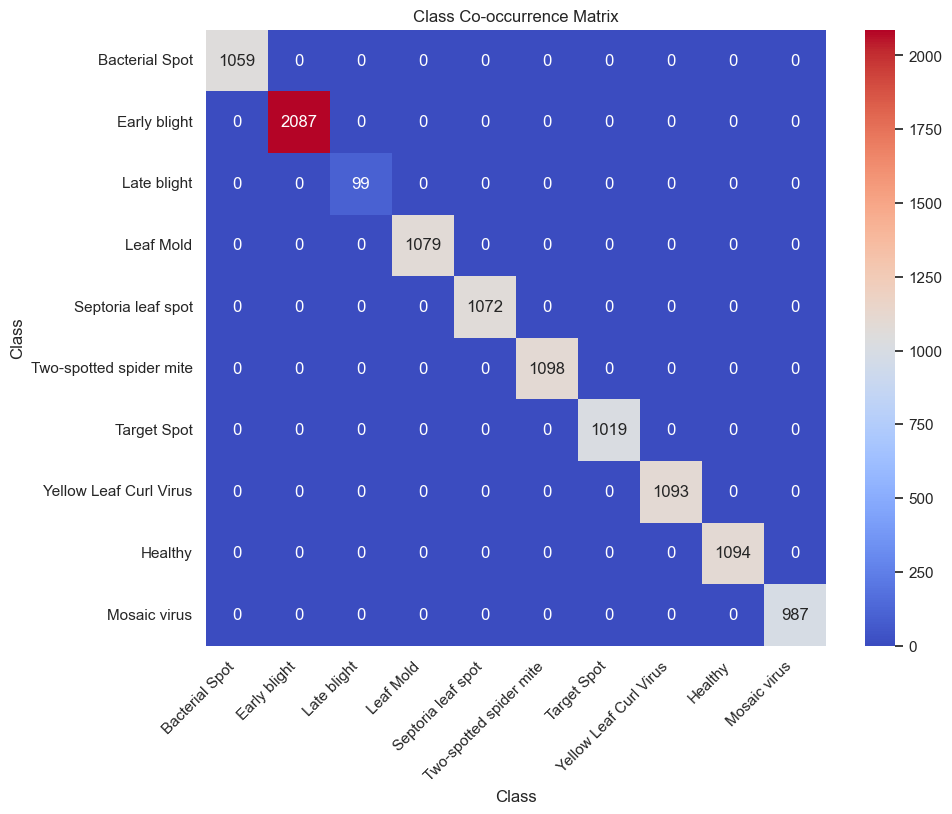

In [54]:
# Co-occurrence Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cooccurrence_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Class Co-occurrence Matrix")
plt.xlabel("Class")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Class")
plt.savefig(reports_figures_dir / "cooccurrence_matrix_heatmap.png")
plt.show()

In [55]:
###==================================
# Section: Class Distribution
###==================================

In [56]:
def analyze_additional_bbox_stats(label_dir: Path, class_names: list[str], image_size=(640, 640), save_dir: Path = None):
    """
    Perform additional analysis on YOLO bounding boxes: class distribution, area, heatmaps.
    """
    class_counts = defaultdict(int)
    bbox_areas = []
    heatmap = np.zeros(image_size)

    print("\nRunning extended bounding box analysis...")

    for label_file in tqdm(sorted(label_dir.glob("*.txt"))):
        with open(label_file, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:
                continue

            class_id, x_center, y_center, width, height = map(float, parts[:5])
            class_counts[int(class_id)] += 1
            bbox_areas.append(width * height)

            # Convert to pixel coords for heatmap
            px = int(x_center * image_size[0])
            py = int(y_center * image_size[1])
            if 0 <= px < image_size[0] and 0 <= py < image_size[1]:
                heatmap[py, px] += 1

    # --- Class Distribution ---
    plt.figure(figsize=(10, 6))
    labels = [class_names[i] if i < len(class_names) else f"Class {i}" for i in class_counts.keys()]
    sns.barplot(x=labels, y=list(class_counts.values()), palette="viridis")
    plt.title("Class Frequency Distribution")
    plt.xlabel("Class")
    plt.ylabel("Instances")
    plt.xticks(rotation=45)
    plt.tight_layout()
    if save_dir:
        path = save_dir / "class_distribution.png"
        plt.savefig(path)
        print(f"Saved: {path.name}")
    plt.show()

    # --- BBox Area Distribution ---
    plt.figure(figsize=(10, 6))
    sns.histplot(bbox_areas, bins=30, kde=True, color="green")
    plt.title("Bounding Box Area Distribution")
    plt.xlabel("Area (w * h, YOLO-relative)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    if save_dir:
        path = save_dir / "bbox_area_distribution.png"
        plt.savefig(path)
        print(f"Saved: {path.name}")
    plt.show()

    # --- Heatmap ---
    plt.figure(figsize=(8, 8))
    sns.heatmap(heatmap, cmap="hot", cbar=True)
    plt.title("Bounding Box Center Heatmap")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    if save_dir:
        path = save_dir / "bbox_heatmap.png"
        plt.savefig(path)
        print(f"Saved: {path.name}")
    plt.show()


Running extended bounding box analysis...


100%|█████████████████████████████████████████████████████████████████████████| 10853/10853 [00:00<00:00, 21916.11it/s]


Saved: class_distribution.png


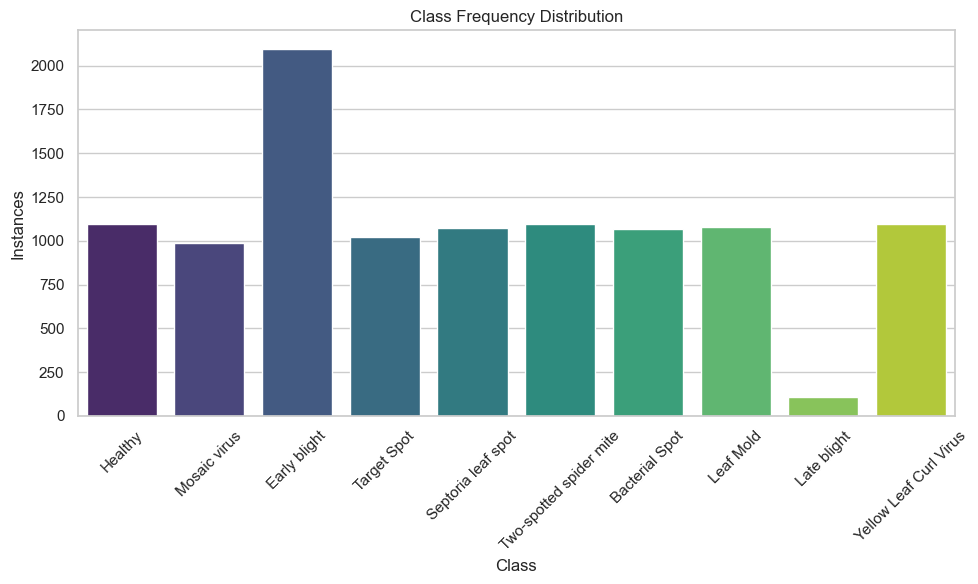

Saved: bbox_area_distribution.png


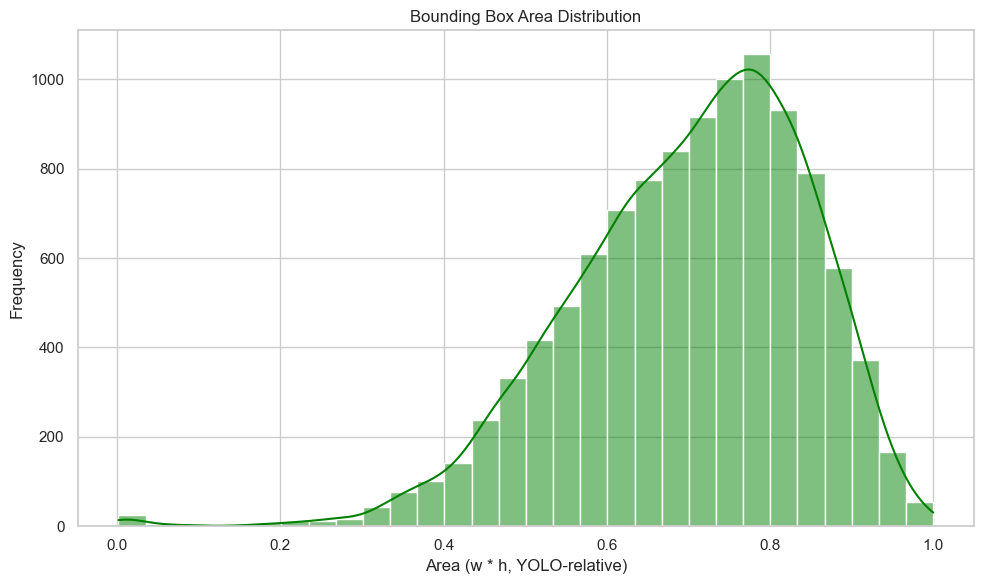

Saved: bbox_heatmap.png


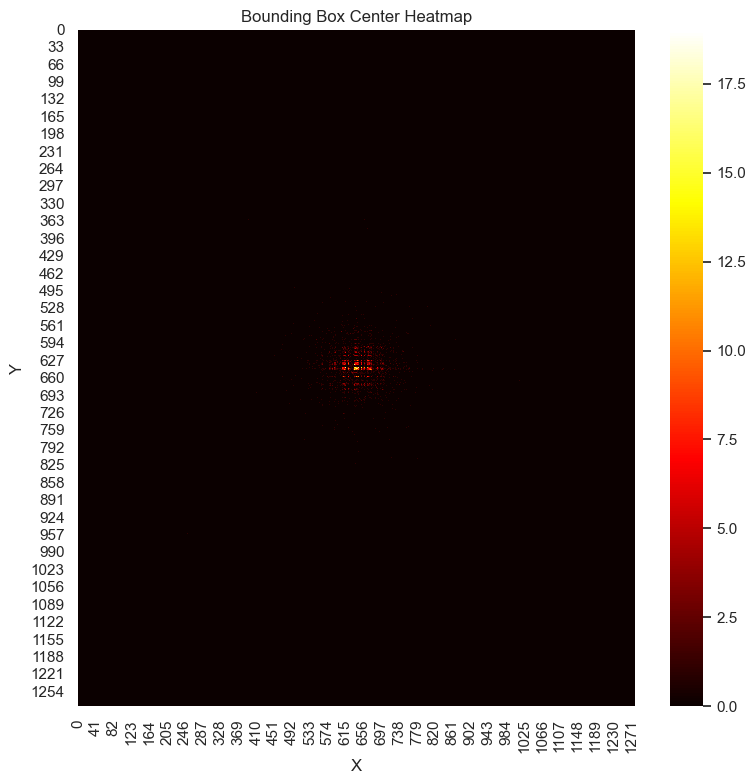

In [57]:
# --- Extra analysis ---
analyze_additional_bbox_stats(
    label_dir=raw_label_dir ,
    class_names=CLASS_NAMES,
    image_size=(1280, 1280),  # Use expected size or max size in dataset
    save_dir=reports_figures_dir
)

In [58]:
def compute_image_channel_stats(image_dir: Path, sample_limit: int = None):
    """
    Compute mean and std dev per image channel.
    """
    print("Computing RGB channel statistics...")

    image_paths = list(image_dir.glob("*"))
    if sample_limit:
        image_paths = image_paths[:sample_limit]

    r_vals, g_vals, b_vals = [], [], []

    for img_path in tqdm(image_paths):
        try:
            img = Image.open(img_path).convert("RGB")
            img_array = np.array(img).astype(np.float32) / 255.0
            r, g, b = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2]

            r_vals.append(r.mean())
            g_vals.append(g.mean())
            b_vals.append(b.mean())
        except Exception as e:
            print(f"Error in {img_path.name}: {e}")

    print(f"Red   - Mean: {np.mean(r_vals):.4f}, Std: {np.std(r_vals):.4f}")
    print(f"Green - Mean: {np.mean(g_vals):.4f}, Std: {np.std(g_vals):.4f}")
    print(f"Blue  - Mean: {np.mean(b_vals):.4f}, Std: {np.std(b_vals):.4f}")

In [59]:
# --- Channel Stats ---
compute_image_channel_stats(
    image_dir=raw_image_dir,
    sample_limit=11000
)

Computing RGB channel statistics...


100%|███████████████████████████████████████████████████████████████████████████| 10853/10853 [01:20<00:00, 134.09it/s]


Red   - Mean: 0.4532, Std: 0.0700
Green - Mean: 0.4637, Std: 0.0635
Blue  - Mean: 0.4188, Std: 0.0687


In [60]:
def bbox_position_density(label_dir: Path, save_dir: Path = None):
    x_centers, y_centers = [], []

    for label_file in label_dir.glob("*.txt"):
        with open(label_file, "r") as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            _, x, y, _, _ = map(float, parts[:5])
            x_centers.append(x)
            y_centers.append(y)

    # X and Y center distributions
    for centers, axis_name in [(x_centers, "X"), (y_centers, "Y")]:
        plt.figure(figsize=(10, 5))
        sns.histplot(centers, bins=50, kde=True, color='purple')
        plt.title(f"BBox Center {axis_name}-Position Distribution")
        plt.xlabel(f"{axis_name}-center (relative)")
        plt.ylabel("Frequency")
        if save_dir:
            save_path = save_dir / f"bbox_center_{axis_name.lower()}_distribution.png"
            plt.savefig(save_path)
            print(f"Saved: {save_path.name}")
        plt.show()

Saved: bbox_center_x_distribution.png


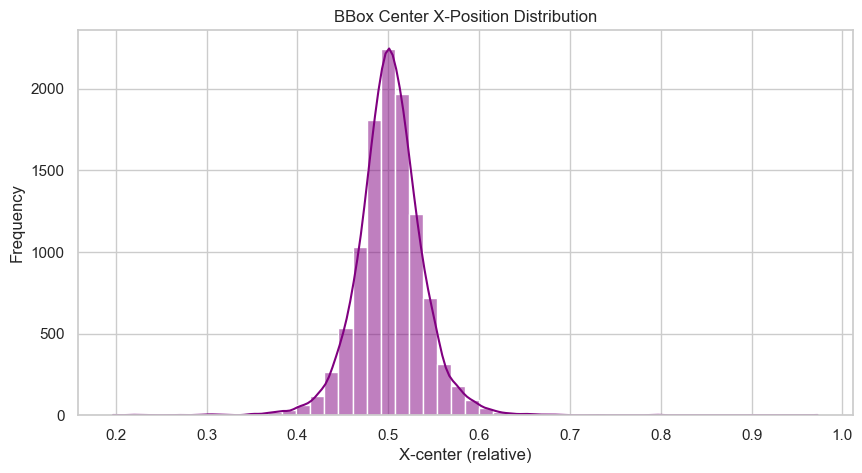

Saved: bbox_center_y_distribution.png


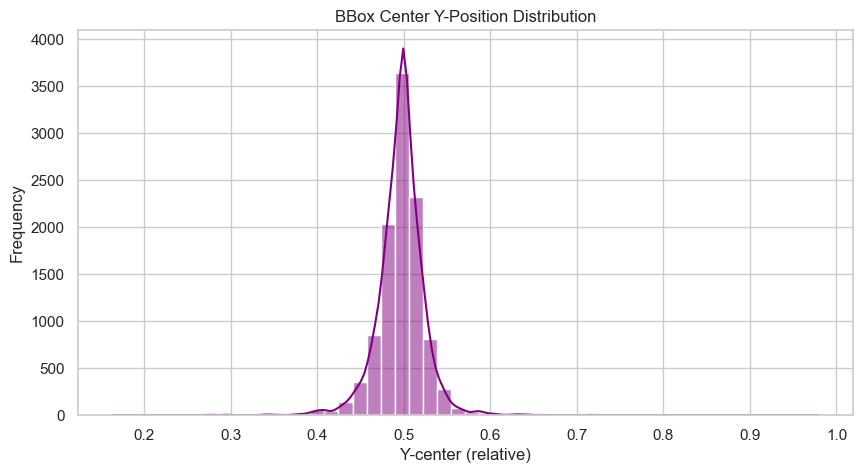

In [61]:
# --- BBox Center Position Density ---
bbox_position_density(
    label_dir=raw_label_dir,
    save_dir=reports_figures_dir
)